# Transfer learning for Diabetic Retinopathy and Normal Eye Fundus

## Libraries

In [1]:
import os
import csv
import PIL
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model, model_from_json, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

In [2]:
tf.__version__

'2.10.0'

## Data exploration

In [3]:
# Creating CSV file path and its headers

csv_file_path = 'D:\\Kuliah\\Proyek Akhir 2022\\dataset_dr_normal.csv'
headers = ['Image', 'Label']

In [4]:
# Write the CSV file

with open(csv_file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(headers)

In [5]:
# Fill the CSV file with the image path and their label

supported_extensions = ['.png', '.jpg', '.jpeg']

for root, dirs, files in os.walk('D:\\Kuliah\\Proyek Akhir 2022\\Dataset (DR-Normal)\\'):
    for file in files:
        if any(file.lower().endswith(ext) for ext in supported_extensions):
            image_path = os.path.join(root, file)
            label = os.path.basename(root)
            with open(csv_file_path, 'a', newline='') as csv_file:
                writer = csv.writer(csv_file)
                writer.writerow([file, label])

In [6]:
# Load and preview the CSV dataset file

dr_df = pd.read_csv('D:\\Kuliah\\Proyek Akhir 2022\\dataset_dr_normal.csv')
dr_df

,Image,Label
0,dr - 5 - 1 (1).jpg,Diabetic Retinopathy
1,dr - 5 - 1 (10).jpg,Diabetic Retinopathy
2,dr - 5 - 1 (100).jpg,Diabetic Retinopathy
3,dr - 5 - 1 (101).jpg,Diabetic Retinopathy
4,dr - 5 - 1 (102).jpg,Diabetic Retinopathy
...,...,...
12517,dr - 5 - 0 (995).jpg,Normal
12518,dr - 5 - 0 (996).jpg,Normal
12519,dr - 5 - 0 (997).jpg,Normal
12520,dr - 5 - 0 (998).jpg,Normal


In [7]:
# The dataset inside the CSV file has around 9534 list of images

print('DR dataset shape:', dr_df.shape)
print('DR dataset axes:', dr_df.axes)

DR dataset shape: (12522, 2)
DR dataset axes: [RangeIndex(start=0, stop=12522, step=1), Index(['Image', 'Label'], dtype='object')]


In [8]:
# Print the classes used for the classification

print('The labels are:', dr_df['Label'].unique())

The labels are: ['Diabetic Retinopathy' 'Normal']


In [9]:
# Count each class images

print(dr_df.groupby('Label')['Image'].nunique())

print('\nType:', type(dr_df.groupby('Label')['Image'].nunique()))

label_count = dr_df.groupby('Label')['Image'].nunique()
label_count = label_count.to_numpy()
print('\nLabel count:', label_count)

Label
Diabetic Retinopathy    6256
Normal                  6266
Name: Image, dtype: int64

Type: <class 'pandas.core.series.Series'>

Label count: [6256 6266]


In [10]:
print(dr_df.iloc[[0]]['Image'])
print(dr_df.iloc[[100]]['Image'])

0    dr - 5 - 1 (1).jpg
Name: Image, dtype: object
100    dr - 5 - 1 (19).jpg
Name: Image, dtype: object


[Text(0, 0, '6256'), Text(0, 0, '6266')]

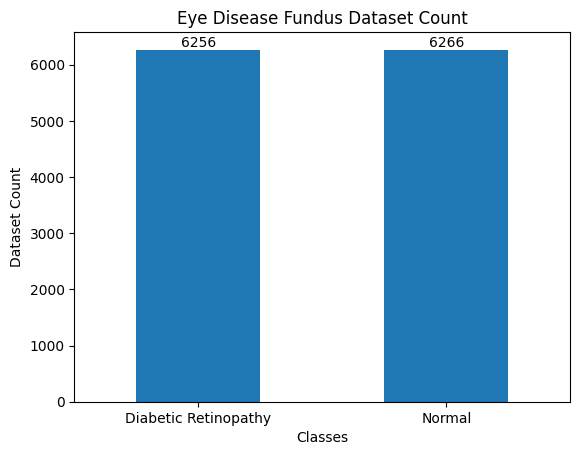

In [11]:
# Plotting the dataset count in each class

dataset_df_chart = dr_df.groupby('Label')['Image'].nunique().plot(kind='bar', 
                                                                        title='Eye Disease Fundus Dataset Count',
                                                                        xlabel='Classes',
                                                                        ylabel='Dataset Count',
                                                                        rot=0)

dataset_df_chart.bar_label(dataset_df_chart.containers[0])

In [12]:
# Set the dataset base directory

os.chdir('D:\\Kuliah\\Proyek Akhir 2022\\Dataset (DR-Normal) (Splitted)')
dataset_dir = os.getcwd()
print('Dataset directory:', dataset_dir)

Dataset directory: D:\Kuliah\Proyek Akhir 2022\Dataset (DR-Normal) (Splitted)


In [13]:
# Set the train, val, and test dataset path

train_url = dataset_dir + '\\train'
val_url = dataset_dir + '\\val'
test_url = dataset_dir + '\\test'

train_dir = pathlib.Path(train_url)
val_dir = pathlib.Path(val_url)
test_dir = pathlib.Path(test_url)

print('train_url\t:', train_url)
print('val_url\t\t:', val_url)
print('test_url\t:', test_url)

print('\ntrain_dir\t:', train_dir)
print('val_dir\t\t:', val_dir)
print('test_dir\t:', test_dir)

train_url	: D:\Kuliah\Proyek Akhir 2022\Dataset (DR-Normal) (Splitted)\train
val_url		: D:\Kuliah\Proyek Akhir 2022\Dataset (DR-Normal) (Splitted)\val
test_url	: D:\Kuliah\Proyek Akhir 2022\Dataset (DR-Normal) (Splitted)\test

train_dir	: D:\Kuliah\Proyek Akhir 2022\Dataset (DR-Normal) (Splitted)\train
val_dir		: D:\Kuliah\Proyek Akhir 2022\Dataset (DR-Normal) (Splitted)\val
test_dir	: D:\Kuliah\Proyek Akhir 2022\Dataset (DR-Normal) (Splitted)\test


In [14]:
# Image count in each dataset

train_count = len(list(train_dir.glob('*/*')))
val_count = len(list(val_dir.glob('*/*')))
test_count = len(list(test_dir.glob('*/*')))

print('Total training set images:\t', train_count)
print('Total validation set images\t:', val_count)
print('Total test set images\t\t:', test_count)

Total training set images:	 11269
Total validation set images	: 625
Total test set images		: 628


In [15]:
# Create dictionary of datagens and generators from each dataset

data_dicts = {
    'train':[],
    'test':[],
    'val':[]
}

data_labels = {
    'train':[],
    'test':[],
    'val':[]
}

### Find the classes distribution

Train information
---------------
Label names		: ['Diabetic Retinopathy', 'Normal']
Label counts		: [5630, 5639]
Total image count	: 11269 

Val information
---------------
Label names		: ['Diabetic Retinopathy', 'Normal']
Label counts		: [312, 313]
Total image count	: 625 

Test information
---------------
Label names		: ['Diabetic Retinopathy', 'Normal']
Label counts		: [314, 314]
Total image count	: 628 



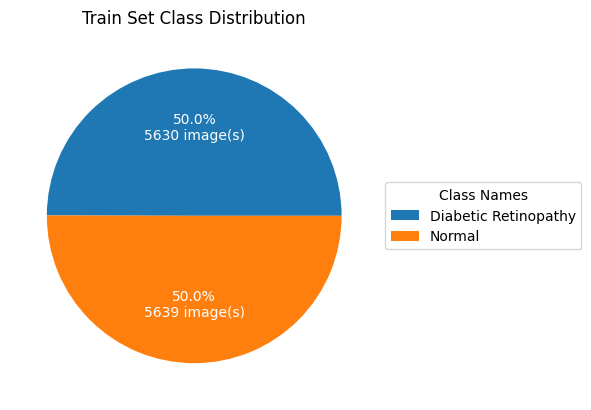

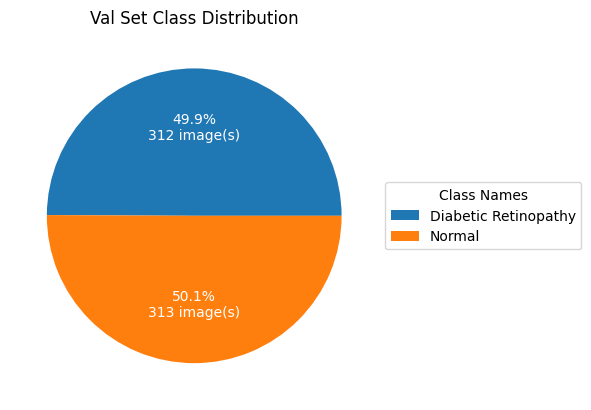

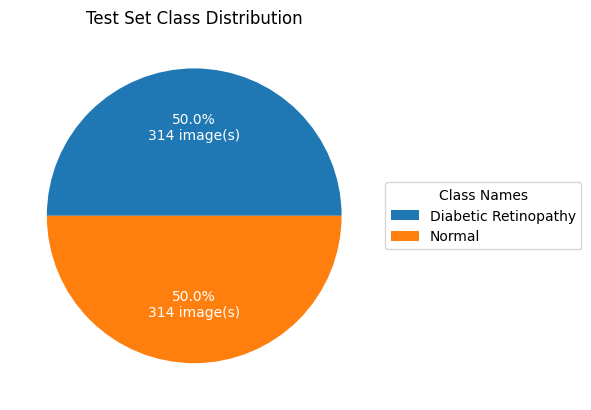

In [16]:
# Set and plot each dataset's classes distribution

for phase in ['train', 'val', 'test']:
    if phase == 'train':
        data_dir = train_dir
    elif phase == 'val':
        data_dir = val_dir
    elif phase == 'test':
        data_dir = test_dir

    class_names = sorted(x for x in os.listdir(data_dir)
                            if os.path.isdir(os.path.join(data_dir, x)))
    num_class = len(class_names) 

    image_files = [[
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ] for i in range(num_class)]

    num_each = [len(image_files[i]) for i in range(num_class)]
    image_files_list = [] 
    image_class = []

    for i in range(num_class):
        image_files_list.extend(image_files[i])
        image_class.extend([i] * num_each[i])

    data_dicts[phase] = image_files_list
    data_labels[phase] = image_class
    num_total = len(image_class)
    image_width, image_height = PIL.Image.open(image_files_list[0]).size
    
    print(f'{phase.capitalize()} information')
    print('-'*15)
    print(f'Label names\t\t: {class_names}')
    print(f'Label counts\t\t: {num_each}')
    print(f'Total image count\t: {num_total}', '\n')

    def func(pct, allvals):
        absolute = int(np.round(pct/100.*np.sum(allvals)))
        return f"{pct:.1f}%\n{absolute:d} image(s)"

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(num_each, 
                                        labels=class_names, 
                                        autopct=lambda pct: func(pct, num_each), 
                                        textprops=dict(color='w'))
    ax.legend(wedges, 
                class_names,
                title='Class Names',
                loc='center left',
                bbox_to_anchor=(1, 0, 0.5, 1))
    ax.set_title(f'{phase.capitalize()} Set Class Distribution')
    plt.tight_layout()

In [17]:
# Set some training hyperparameters

BATCH_SIZE = 32

IMG_SIZE_1 = 32
IMG_SIZE_2 = 64
IMG_SIZE_3 = 100
IMG_SIZE_4 = 128
IMG_SIZE_5 = 180
IMG_SIZE_6 = 224
IMG_SIZE_7 = 256
IMG_SIZE = (IMG_SIZE_3, IMG_SIZE_3)

print('BATCH_SIZE:', BATCH_SIZE)
print('IMG_SIZE:', IMG_SIZE, '| IMG_SIZE type:', type(IMG_SIZE))

BATCH_SIZE: 32
IMG_SIZE: (100, 100) | IMG_SIZE type: <class 'tuple'>


## Data loading & augmentation

In [18]:
# Create the datagen for each dataset using ImageDataGenerator (this library is deprecated since TF 2.10)

from tensorflow.keras.applications.efficientnet_v2 import preprocess_input # Adjust with the model we want to use

datagen = {
    'train': ImageDataGenerator(
        # rescale=1/255.0,
        vertical_flip=True,
        horizontal_flip=True,
        rotation_range=20,
        fill_mode='constant',
        # shear_range=5.0,
        # zoom_range=[0.5, 1.0],
        # brightness_range=(0.5, 1.5),
        # width_shift_range=(0.0, 0.15),
        # height_shift_range=(0.0, 0.15),
        # preprocessing_input=preprocess_input

    ),
    'val': ImageDataGenerator(
        # rescale=1/255.0,
    ),
    'test': ImageDataGenerator(
        # rescale=1/255.0,
    ),
}

In [19]:
# Create the image generator for each dataset using ImageDataGenerator (this library is deprecated since TF 2.10)

test_image_source = 'D:\\Kuliah\\Proyek Akhir 2022\\eye-disease-classification-app\\deep-learning-model\\dr_test_images\\dr - 5 - 2 (511).jpg'
augmentation_dest_path = 'D:\\Kuliah\\Proyek Akhir 2022\\eye-disease-classification-app\\deep-learning-model\\dr_augmentations_examples'

data_sets = {
    'train': datagen['train'].flow_from_directory(
        train_dir, 
        shuffle=True, 
        seed=42, 
        class_mode='binary', 
        batch_size=BATCH_SIZE, 
        target_size=IMG_SIZE,

        # Uncomment this beneath line if we want to preview and save some augmented images
        # save_to_dir=augmentation_dest_path,
        # save_prefix='aug',
        # save_format='png'
    ),
    'val': datagen['val'].flow_from_directory(
        val_dir, 
        shuffle=True, 
        class_mode='binary', 
        batch_size=BATCH_SIZE, 
        target_size=IMG_SIZE,
    ),
    'test': datagen['test'].flow_from_directory(
        test_dir, 
        shuffle=False, 
        class_mode='binary', 
        batch_size=BATCH_SIZE, 
        target_size=IMG_SIZE
    )
}

Found 11269 images belonging to 2 classes.
Found 625 images belonging to 2 classes.
Found 628 images belonging to 2 classes.


In [20]:
# Uncomment this section if we want to preview and save some augmented images

# 
# test_image_source = 'D:\\Kuliah\\Proyek Akhir 2022\\eye-disease-classification-app\\deep-learning-model\\dr_test_images\\dr - 5 - 2 (511).jpg'
# augmentation_dest_path = 'D:\\Kuliah\\Proyek Akhir 2022\\eye-disease-classification-app\\deep-learning-model\\dr_augmentations_examples'
# 
# i = 0
# 
# for batch in data_sets['train']:
#     i = i + 1
#     if i >= 30:
#         break

In [21]:
# Let's take a look at the dataset properties after being created with ImageDataGenerator 

for i, (images, labels) in enumerate(data_sets['train']):
    print('First batch labels:', labels)
    print('Labels shape:', labels.shape)
    print('Images shape:', images.shape)
    break

First batch labels: [1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 1. 0.]
Labels shape: (32,)
Images shape: (32, 100, 100, 3)


### Preview the image dataset

In [22]:
# # Show the nine images and labels from the dataset
# 
# def show_images(GRID=[3,3], model=None, size=(8,8), data_type='train'):
#     n_rows = GRID[0]
#     n_cols = GRID[1]
#     n_images = n_cols * n_rows
#     i = 1
#     plt.figure(figsize=size)
# 
#     data = data_sets[data_type]
# 
#     for images, labels in data:
#         id = np.random.randint(32)
#         image, label = images[id], class_names[int(labels[id])]
#         
#         plt.subplot(n_rows, n_cols, i)
#         plt.imshow(image.astype('uint8'))
#         
#         # if model is None:
#         #     title = f"Class : {label}"
#         # else:
#         #     pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
#         #     title = f"Org : {label}, Pred : {pred}"
#         
#         plt.title(title)
#         
#         if data_type == 'train':
#             plt.suptitle('Preprocessed/Augmented Train Images')
#         elif data_type == 'val':
#             plt.suptitle('Preprocessed/Augmented Validation Images')
#         elif data_type == 'test':
#             plt.suptitle('Preprocessed/Augmented Test Images')
# 
#         plt.axis('on')
#         i+=1
#         
#         if i>=(n_images+1):
#             break
#             
#     plt.tight_layout()
#     plt.show()

def show_images(dataset_type):
    if dataset_type not in ['train', 'val', 'test']:
        raise ValueError("Invalid dataset_type. Choose 'train', 'val', or 'test'.")

    # Set the path to your dataset directory
    # dataset_dir = 'path/to/your/dataset'

    # Set the batch size for previewing images
    batch_size = 9

    # Create an ImageDataGenerator instance for the specified dataset
    # datagen = ImageDataGenerator(rescale=1.0/255.0)
    # dataset = datagen.flow_from_directory(
    #     os.path.join(dataset_dir, dataset_type),
    #     target_size=(224, 224),
    #     batch_size=batch_size,
    #     shuffle=True,
    #     class_mode='categorical'
    # )

    # Get a batch of images and their labels
    images, labels = next(data_sets[dataset_type])

    # Configure the figure for plotting
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    axes = axes.flatten()

    # Plot each image with its corresponding label
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.astype('uint8'))
        ax.set_title(f"Class: {class_names[int(label)]}")
        ax.axis('on')
    
    if dataset_type == 'train':
        plt.suptitle('Preprocessed/Augmented Train Images')
    elif dataset_type == 'val':
        plt.suptitle('Preprocessed/Augmented Validation Images')
    elif dataset_type == 'test':
        plt.suptitle('Preprocessed/Augmented Test Images')

    # Show the plot
    plt.tight_layout()
    plt.show()

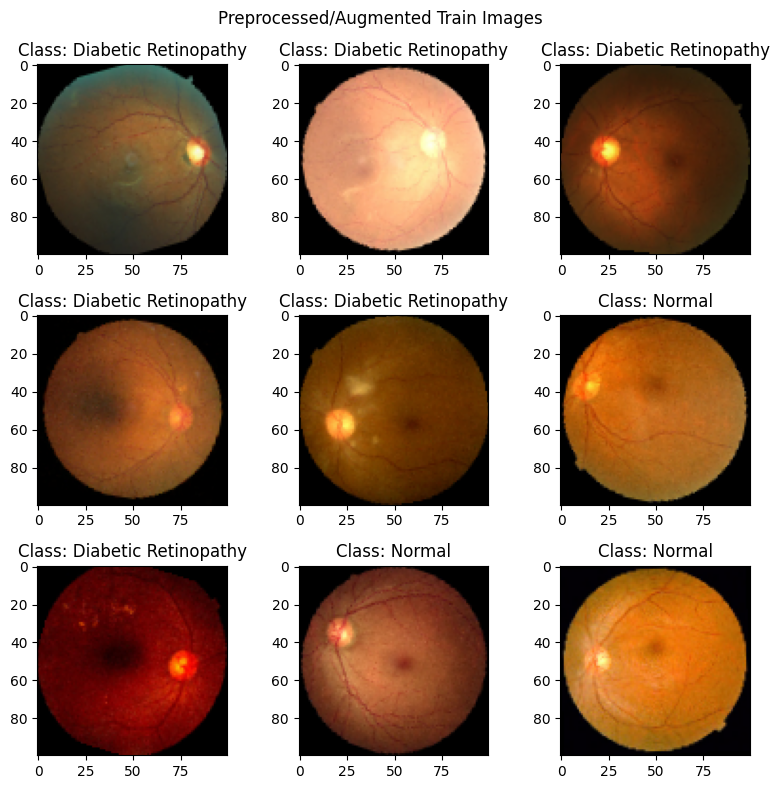

In [23]:
# Check and show images from training data generator

show_images('train')

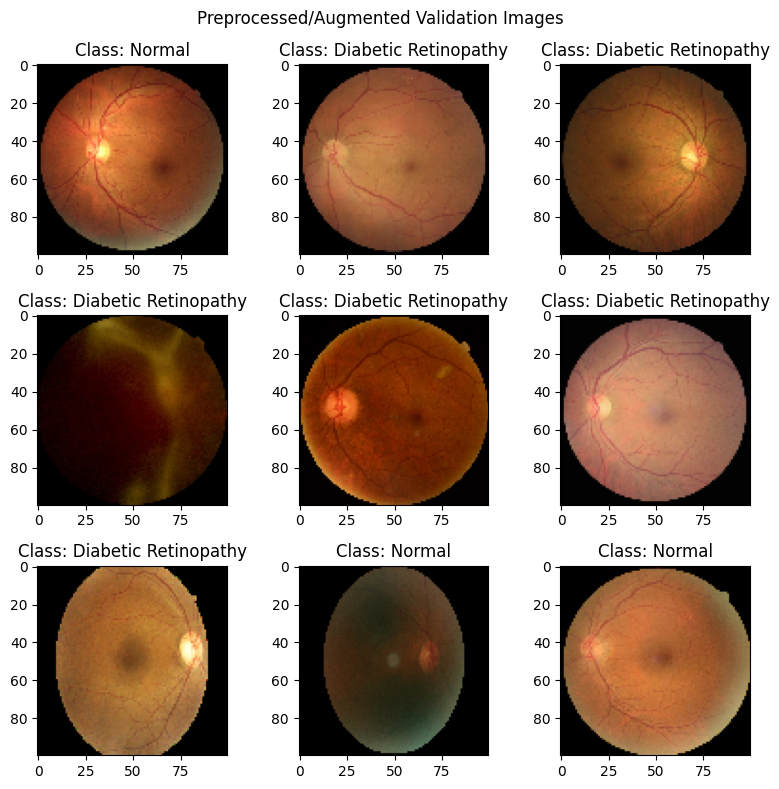

In [24]:
# Check and show images from validation data generator

show_images('val')

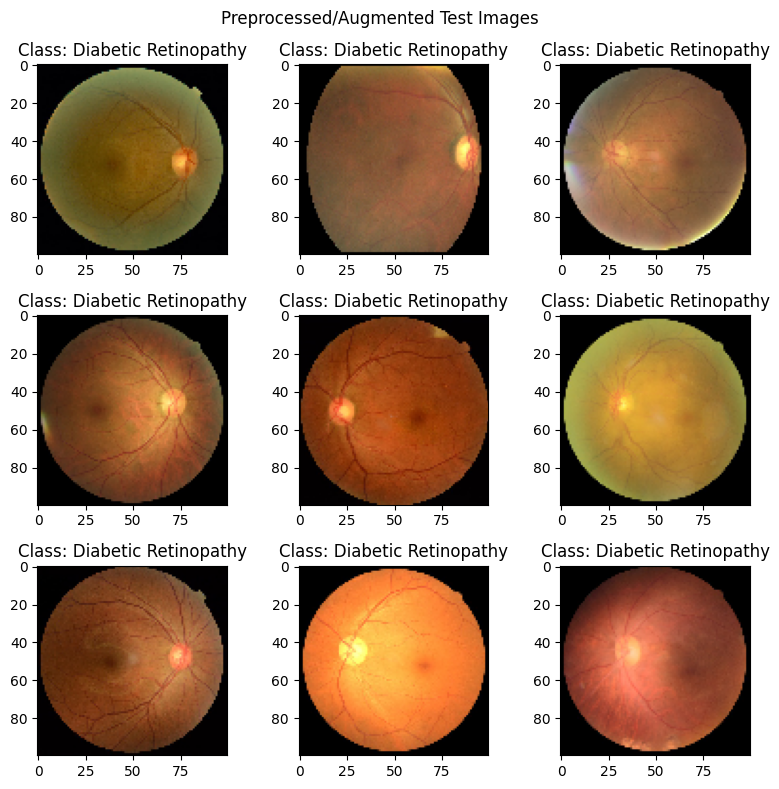

In [25]:
# Check and show images from test data generator

show_images('test')

## Create the base model

In [26]:
# Create the base model from the pre-trained model - EfficientNetV2B2

IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.EfficientNetV2B2(input_shape=IMG_SHAPE,
                                                    include_top=False,
                                                    weights='imagenet')

## Feature extraction

In [27]:
# Showing all layers name in the base model

for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block1b_project_conv
10 block1b_project_bn
11 block1b_project_activation
12 block1b_drop
13 block1b_add
14 block2a_expand_conv
15 block2a_expand_bn
16 block2a_expand_activation
17 block2a_project_conv
18 block2a_project_bn
19 block2b_expand_conv
20 block2b_expand_bn
21 block2b_expand_activation
22 block2b_project_conv
23 block2b_project_bn
24 block2b_drop
25 block2b_add
26 block2c_expand_conv
27 block2c_expand_bn
28 block2c_expand_activation
29 block2c_project_conv
30 block2c_project_bn
31 block2c_drop
32 block2c_add
33 block3a_expand_conv
34 block3a_expand_bn
35 block3a_expand_activation
36 block3a_project_conv
37 block3a_project_bn
38 block3b_expand_conv
39 block3b_expand_bn
40 block3b_expand_activation
41 block3b_project_conv
42 block3b_project_bn
43 block3b_drop
44 block3b_add
45 block3c_expand_conv
46 block3c_expand_bn
47 block3c_

### Freeze the trainable layers

In [28]:
base_model.trainable = False

In [29]:
# Take a look at the base model architecture

base_model.summary()

Model: "efficientnetv2-b2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 100, 100, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 100, 100, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 50, 50, 32)   864         ['normalization[0

### Add additional top layers

In [30]:
# Create the whole model with some additional top layers

model = tf.keras.Sequential()
model.add(base_model)

# from this layers to the top layer can be modified for further experiments
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 1 unit because this is a binary classification

In [31]:
# Take a look at the new whole model architecture now
# Based on layers that we have added in the code above, we can observe from the model summary in 
# "trainable params" section that there are additional layers 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b2 (Function  (None, 4, 4, 1408)       8769374   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               360704    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 6

### Compile the model

In [32]:
BASE_LR = 0.0001

model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LR), # Optimizers could be changed for further experiments
      loss='binary_crossentropy',
      metrics=['accuracy',
            #    tf.keras.metrics.BinaryAccuracy(),
            #    tf.keras.metrics.Precision(),
            #    tf.keras.metrics.Recall(),
            #    tf.keras.metrics.AUC(),
            #    tf.keras.metrics.TruePositives(),
            #    tf.keras.metrics.TrueNegatives(),
            #    tf.keras.metrics.FalsePositives(),
            #    tf.keras.metrics.FalseNegatives()
      ])

In [33]:
# Check again whether this model summary is different from before or not

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b2 (Function  (None, 4, 4, 1408)       8769374   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               360704    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 6

In [34]:
len(model.trainable_variables)

8

In [35]:
# Try to evaluate the model using validation dataset before training process

loss0, accuracy0 = model.evaluate(data_sets['val'])

print("Initial loss: {:.2f}".format(loss0))
print("Initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 19s 565ms/step - loss: 0.7099 - accuracy: 0.4752
Initial loss: 0.71
Initial accuracy: 0.48


### Define some model callbacks

In [36]:
# Define some callbacks for the model

trained_model_path = 'D:\\Kuliah\\Proyek Akhir 2022\\eye-disease-classification-app\\deep-learning-model\\trained_model\\'

# Model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    trained_model_path + 'efficientnetv2b2_dr_best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5, # This could be changed in the future for further experiments
    verbose=1,
    restore_best_weights=True,
    min_delta=0.1 # This could be changed in the future for further experiments
)

# Reduce LR on Plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.8,
    patience=3, 
    min_lr=1e-5, 
    verbose=1
)

# Tensorboard
tensorboard = tf.keras.callbacks.TensorBoard('./tb_logs/run_logs')

### Train the whole model

In [37]:
INIT_EPOCH = 30 # This could be changed for further experiments

history = model.fit(data_sets['train'],
                    epochs=INIT_EPOCH,
                    validation_data=data_sets['val'],
                    callbacks=[model_checkpoint, tensorboard])

Epoch 1/30
353/353 [==============================] - ETA: 0s - loss: 0.5493 - accuracy: 0.7213
Epoch 1: val_loss improved from inf to 0.52389, saving model to D:\Kuliah\Proyek Akhir 2022\eye-disease-classification-app\deep-learning-model\trained_model\efficientnetv2b2_dr_best_model.h5
353/353 [==============================] - 365s 1s/step - loss: 0.5493 - accuracy: 0.7213 - val_loss: 0.5239 - val_accuracy: 0.7344
Epoch 2/30
353/353 [==============================] - ETA: 0s - loss: 0.4861 - accuracy: 0.7618
Epoch 2: val_loss improved from 0.52389 to 0.45662, saving model to D:\Kuliah\Proyek Akhir 2022\eye-disease-classification-app\deep-learning-model\trained_model\efficientnetv2b2_dr_best_model.h5
353/353 [==============================] - 444s 1s/step - loss: 0.4861 - accuracy: 0.7618 - val_loss: 0.4566 - val_accuracy: 0.7840
Epoch 3/30
353/353 [==============================] - ETA: 0s - loss: 0.4632 - accuracy: 0.7728
Epoch 3: val_loss improved from 0.45662 to 0.44316, saving mod

### Learning curves

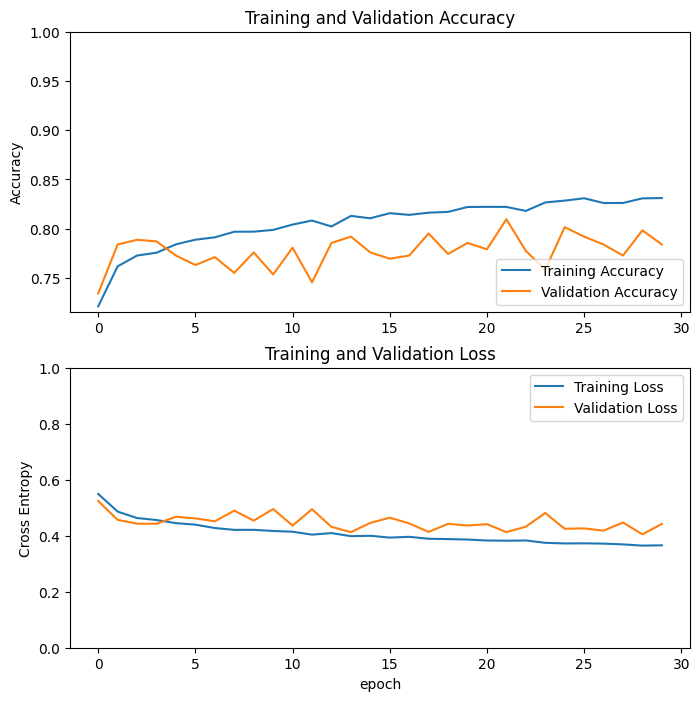

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

**Explanation of fine tuning**

In the feature extraction experiment, we were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier we added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after we have trained the top-level classifier with the pre-trained model set to non-trainable. If we add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and our pre-trained model will forget what it has learned.

Also, we should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As we go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model

In [39]:
# Un-freeze the base model

base_model.trainable = True

In [40]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model:", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100 # This could be changed for further experiments

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model: 349


### Compile the model

In [41]:
model.compile(
    loss='binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=BASE_LR/10),
    metrics=['accuracy',
        # tf.keras.metrics.BinaryAccuracy(),
        # tf.keras.metrics.Precision(),
        # tf.keras.metrics.Recall(),
        # tf.keras.metrics.AUC(),
        # tf.keras.metrics.TruePositives(),
        # tf.keras.metrics.TrueNegatives(),
        # tf.keras.metrics.FalsePositives(),
        # tf.keras.metrics.FalseNegatives()
    ])

In [42]:
# Take a final look at the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b2 (Function  (None, 4, 4, 1408)       8769374   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               360704    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 6

In [43]:
len(model.trainable_variables)

226

### Continue training the model

In [44]:
FINE_TUNE_EPOCHS = 10 # This could be changed for further experiments
total_epochs =  INIT_EPOCH + FINE_TUNE_EPOCHS

history_fine = model.fit(data_sets['train'],
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=data_sets['val'])

Epoch 30/40
353/353 [==============================] - 396s 1s/step - loss: 0.5899 - accuracy: 0.7133 - val_loss: 0.5956 - val_accuracy: 0.7200
Epoch 31/40
353/353 [==============================] - 353s 1s/step - loss: 0.5085 - accuracy: 0.7498 - val_loss: 0.5624 - val_accuracy: 0.7392
Epoch 32/40
353/353 [==============================] - 356s 1s/step - loss: 0.4766 - accuracy: 0.7726 - val_loss: 0.5494 - val_accuracy: 0.7440
Epoch 33/40
353/353 [==============================] - 358s 1s/step - loss: 0.4531 - accuracy: 0.7805 - val_loss: 0.5151 - val_accuracy: 0.7568
Epoch 34/40
353/353 [==============================] - 353s 999ms/step - loss: 0.4391 - accuracy: 0.7905 - val_loss: 0.5210 - val_accuracy: 0.7616
Epoch 35/40
353/353 [==============================] - 425s 1s/step - loss: 0.4240 - accuracy: 0.8003 - val_loss: 0.5063 - val_accuracy: 0.7648
Epoch 36/40
353/353 [==============================] - 424s 1s/step - loss: 0.4199 - accuracy: 0.8022 - val_loss: 0.4999 - val_accura

### Learning curves after fine-tuning

In [45]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

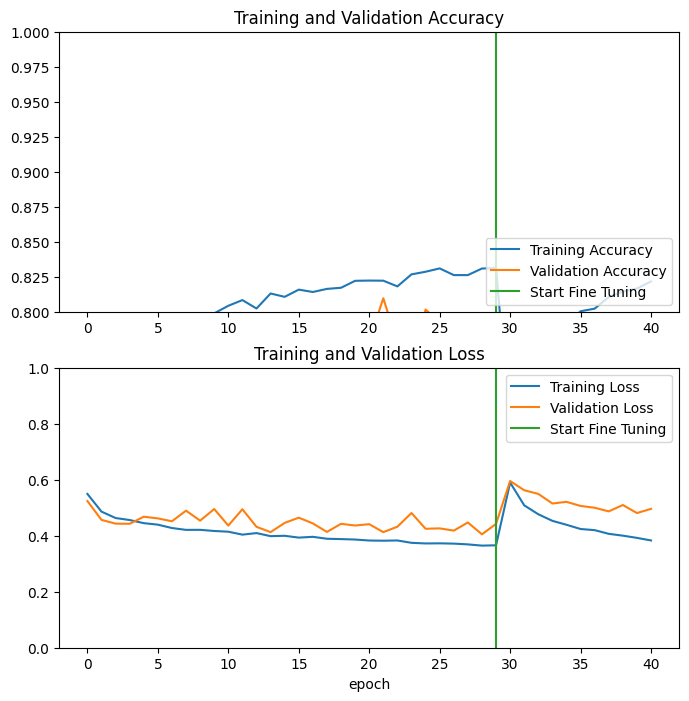

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([INIT_EPOCH-1,INIT_EPOCH-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([INIT_EPOCH-1,INIT_EPOCH-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation on test dataset

In [47]:
loss, accuracy = model.evaluate(data_sets['test'])

print("Test loss: {:.2f}".format(loss))
print("Test accuracy: {:.2f}".format(accuracy))

20/20 [==============================] - 25s 1s/step - loss: 0.4268 - accuracy: 0.7739
Test loss: 0.43
Test accuracy: 0.77


## Prediction on test dataset

In [48]:
# # Retrieve a batch of images from the test set
# image_batch, label_batch = data_sets['train'].as_numpy_iterator().next()
# # predictions = model.predict_on_batch(image_batch).flatten()
# 
# # # Apply a sigmoid since our model returns logits
# # predictions = tf.nn.sigmoid(predictions)
# # predictions = tf.where(predictions < 0.5, 0, 1)
# 
# predicted_batch = model.predict(image_batch)
# predicted_id = tf.math.argmax(predicted_batch, axis=1)
# class_names = np.array(class_names)
# predicted_label_batch = class_names[predicted_id]
# 
# # print('Predictions:\n', predictions.numpy())
# print('Predictions:\n', predicted_label_batch)
# print('Labels:\n', label_batch)
# 
# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   # plt.title(class_names[predictions[i]])
#   plt.title(predicted_label_batch[i])
#   plt.axis("off")

predictions = model.predict(data_sets['test'])
print('Number of predicted images:', len(predictions))
print('Predictions:', predictions)
print('Predictions shape:', predictions.shape)

predictions_df = pd.DataFrame(predictions)

20/20 [==============================] - 23s 865ms/step
Number of predicted images: 628
Predictions: [[7.13490963e-01]
 [7.38507450e-01]
 [7.84563541e-01]
 [6.72614336e-01]
 [5.04979849e-01]
 [1.54598383e-02]
 [7.80343294e-01]
 [5.50818801e-01]
 [4.90894079e-01]
 [1.97018795e-02]
 [8.35615754e-01]
 [1.13369934e-01]
 [1.59575686e-01]
 [7.13684738e-01]
 [7.12152421e-01]
 [8.68100747e-02]
 [7.93876708e-01]
 [7.58450627e-01]
 [7.12976515e-01]
 [4.07184422e-01]
 [2.23403394e-01]
 [3.86009246e-01]
 [8.09172034e-01]
 [3.82293075e-01]
 [9.17990804e-01]
 [6.74924493e-01]
 [2.59405613e-01]
 [6.50803685e-01]
 [9.41822529e-01]
 [1.41397402e-01]
 [8.54464531e-01]
 [7.14702666e-01]
 [6.03009284e-01]
 [8.85721505e-01]
 [6.28566206e-01]
 [1.03847370e-01]
 [5.67511469e-03]
 [1.58624068e-01]
 [9.65968892e-02]
 [5.50901651e-01]
 [7.36183450e-02]
 [3.11198384e-01]
 [8.12918022e-02]
 [2.33304650e-02]
 [2.95093618e-02]
 [1.41313255e-01]
 [2.13768348e-01]
 [3.89719844e-01]
 [3.30836415e-01]
 [5.39423674e-02]

In [49]:
predictions_df

,0
0,0.713491
1,0.738507
2,0.784564
3,0.672614
4,0.504980
...,...
623,0.974136
624,0.778284
625,0.498310
626,0.977702


In [50]:
# Converts each predicted value into labels

predictions_df['y_pred'] = predictions_df[0].apply(lambda x: 1 if x >= 0.5 else 0)
predictions_df

,0,y_pred
0,0.713491,1
1,0.738507,1
2,0.784564,1
3,0.672614,1
4,0.504980,1
...,...,...
623,0.974136,1
624,0.778284,1
625,0.498310,0
626,0.977702,1


In [51]:
# Add y_true into predictions_df

print(data_sets['test'].classes)
predictions_df['y_true'] = data_sets['test'].classes
predictions_df

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

,0,y_pred,y_true
0,0.713491,1,0
1,0.738507,1,0
2,0.784564,1,0
3,0.672614,1,0
4,0.504980,1,0
...,...,...,...
623,0.974136,1,1
624,0.778284,1,1
625,0.498310,0,1
626,0.977702,1,1


In [52]:
predictions_df.columns = ['prediction_results', 'y_pred', 'y_true']
predictions_df

,prediction_results,y_pred,y_true
0,0.713491,1,0
1,0.738507,1,0
2,0.784564,1,0
3,0.672614,1,0
4,0.504980,1,0
...,...,...,...
623,0.974136,1,1
624,0.778284,1,1
625,0.498310,0,1
626,0.977702,1,1


In [53]:
y_pred_in_numpy = np.array(predictions_df['y_pred'])
y_pred_in_numpy

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [54]:
y_true_in_numpy = np.array(predictions_df['y_true'])
y_true_in_numpy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [55]:
# Creating CSV file path and its headers

csv_file_path = 'D:\\Kuliah\\Proyek Akhir 2022\\test_dataset_dr_normal.csv'
headers = ['Image', 'Label']

In [56]:
# Write the CSV file

with open(csv_file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(headers)

In [57]:
# Fill the CSV file with the image path and their label

supported_extensions = ['.png', '.jpg', '.jpeg']

for root, dirs, files in os.walk('D:\\Kuliah\\Proyek Akhir 2022\\Dataset (DR-Normal) (Splitted)\\test'):
    for file in files:
        if any(file.lower().endswith(ext) for ext in supported_extensions):
            image_path = os.path.join(root, file)
            label = os.path.basename(root)
            with open(csv_file_path, 'a', newline='') as csv_file:
                writer = csv.writer(csv_file)
                writer.writerow([file, label])

In [58]:
# Load and preview the CSV dataset file

test_dr_df = pd.read_csv('D:\\Kuliah\\Proyek Akhir 2022\\test_dataset_dr_normal.csv')
test_dr_df

,Image,Label
0,dr - 5 - 1 (102).jpg,Diabetic Retinopathy
1,dr - 5 - 1 (122).jpg,Diabetic Retinopathy
2,dr - 5 - 1 (147).jpg,Diabetic Retinopathy
3,dr - 5 - 1 (151).jpg,Diabetic Retinopathy
4,dr - 5 - 1 (184).jpg,Diabetic Retinopathy
...,...,...
623,dr - 5 - 0 (945).jpg,Normal
624,dr - 5 - 0 (954).jpg,Normal
625,dr - 5 - 0 (974).jpg,Normal
626,dr - 5 - 0 (985).jpg,Normal


Diabetic Retinopathy    314
Normal                  314
Name: Label, dtype: int64

Total predicted images: 628


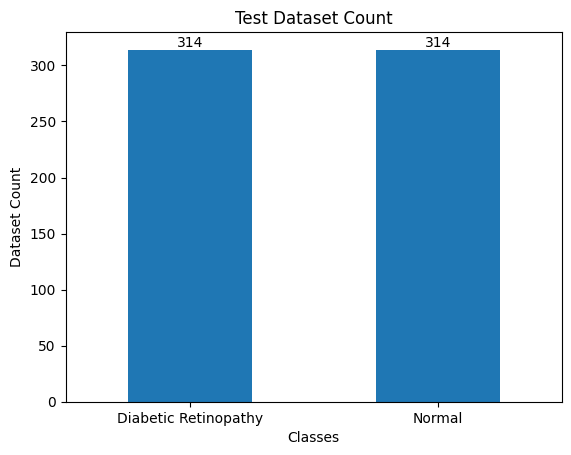

In [59]:
test_dr_df['Label'].value_counts()
print(test_dr_df['Label'].value_counts())

# View the above in a bar graph
test_df_chart = test_dr_df.groupby('Label')['Image'].nunique().plot(kind='bar',
                                                          title='Test Dataset Count',
                                                          xlabel='Classes',
                                                          ylabel='Dataset Count',
                                                          rot=0)

test_df_chart.bar_label(test_df_chart.containers[0])

# Lets print the total predicted images 
print("\nTotal predicted images:", test_dr_df.shape[0])



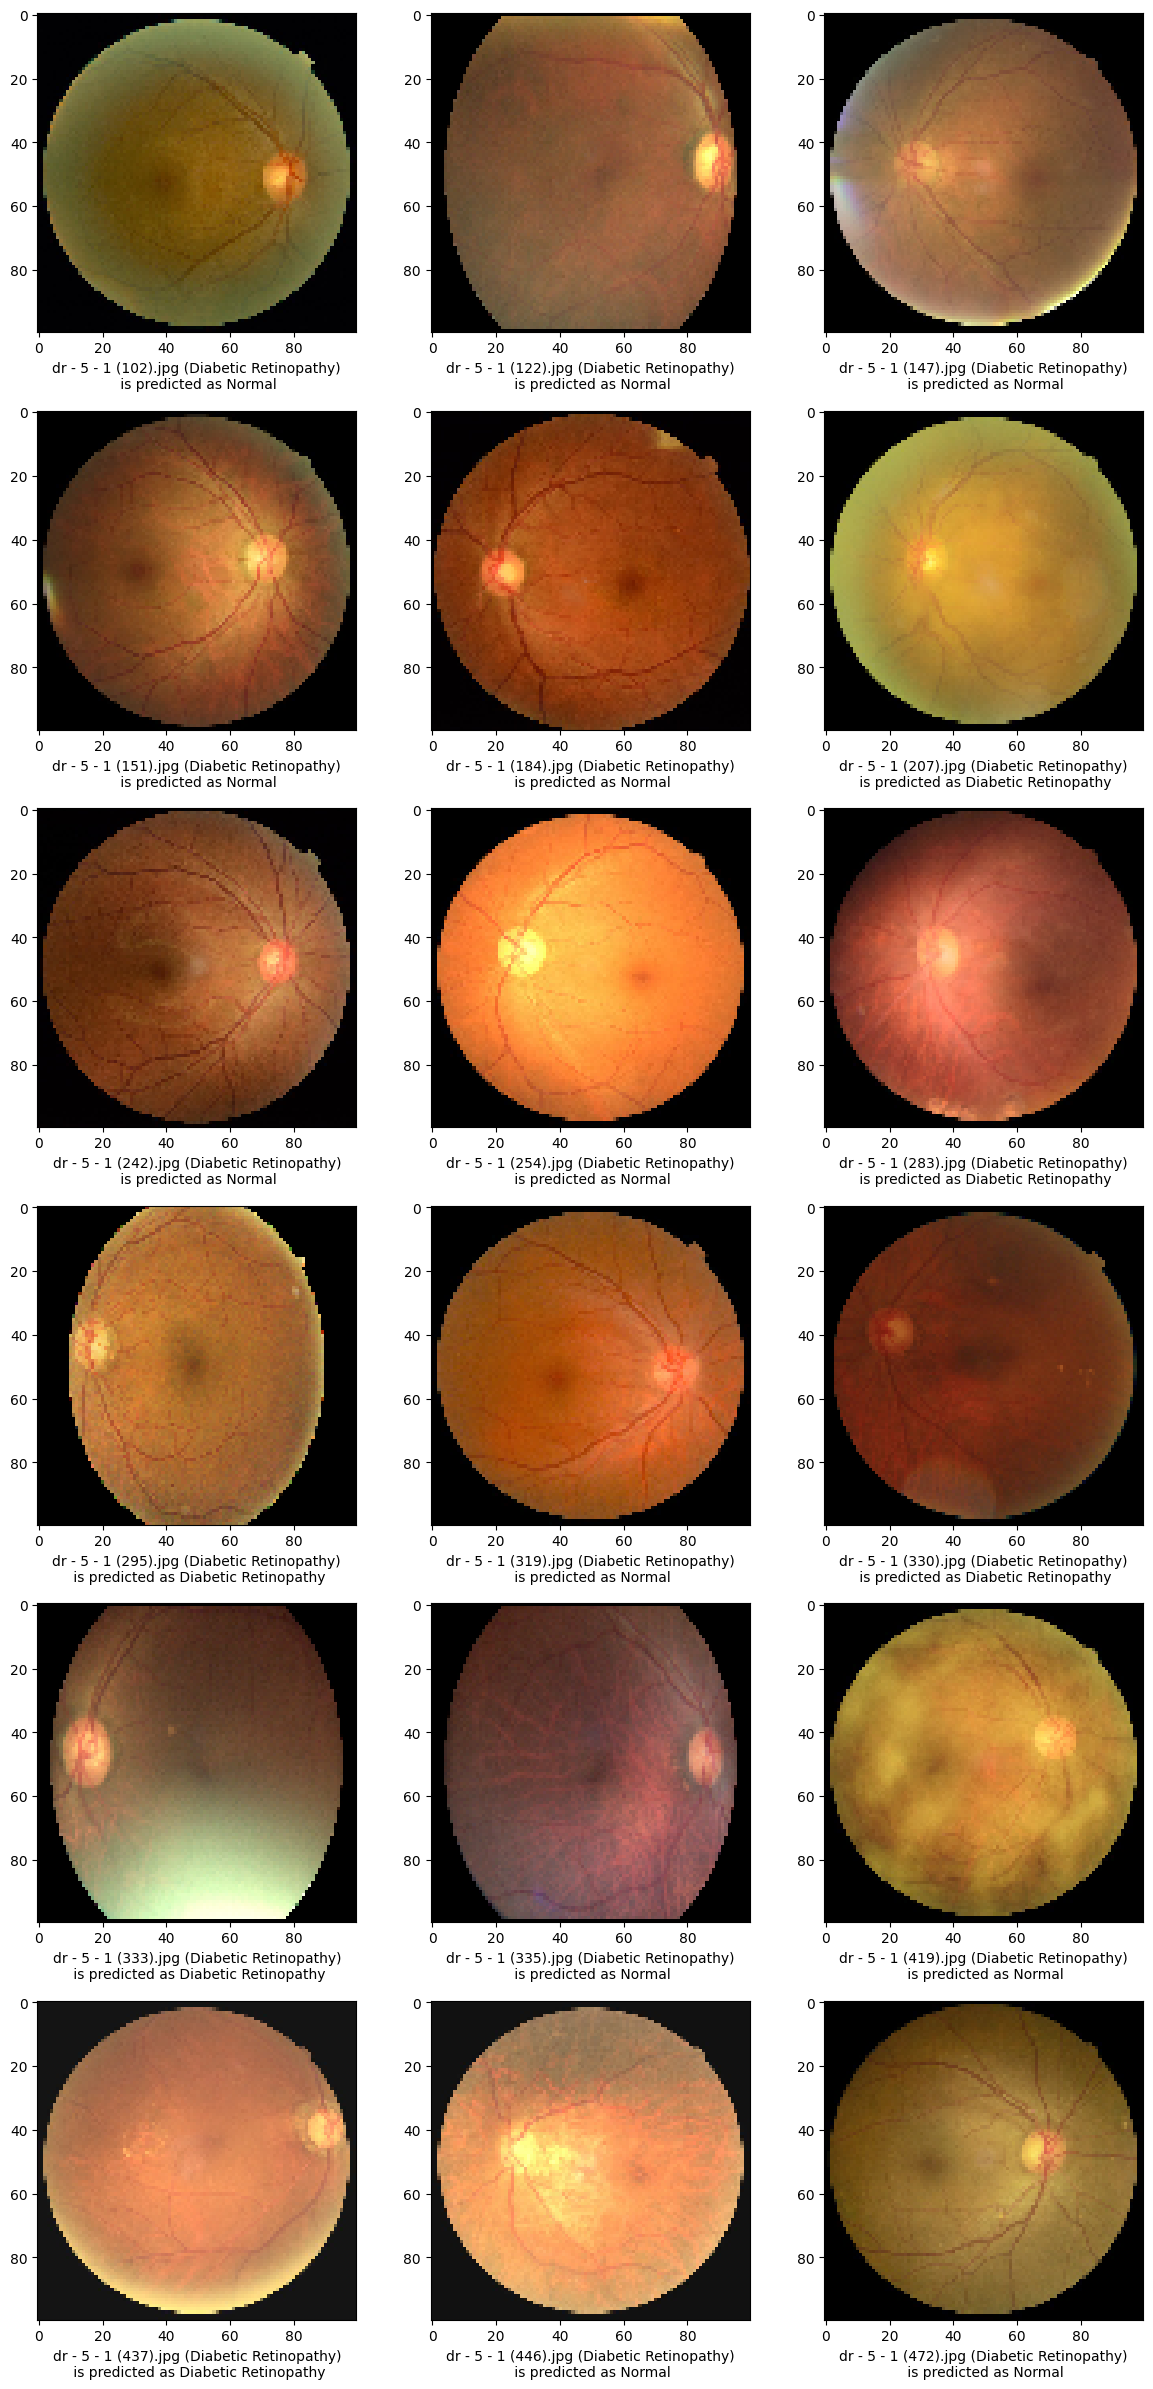

In [60]:
from tensorflow.keras.preprocessing.image import load_img

sample_test = test_dr_df.head(18)
sample_test.head()
class_indices = data_sets['test'].class_indices
plt.figure(figsize=(12, 24))

for index, row in sample_test.iterrows():
    filename = row['Image']
    category = row['Label']
    y_pred = predictions_df['y_pred'][index]
    classes = list(filter(lambda x: class_indices[x] == y_pred, class_indices))[0]
    img = load_img('D:\\Kuliah\\Proyek Akhir 2022\\Dataset (DR-Normal) (Splitted)\\test\\Diabetic Retinopathy\\' + filename, target_size=IMG_SIZE) #rescale(1./255)
    plt.subplot(6, 3, index+1)      
    plt.imshow(img)
    plt.xlabel(filename + f" ({category})\n is predicted as {classes}")

plt.tight_layout()
plt.show()

## Evaluation metrics

In [61]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true_in_numpy, y_pred_in_numpy)))

print('Micro Precision: {:.2f}'.format(precision_score(y_true_in_numpy, y_pred_in_numpy, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_true_in_numpy, y_pred_in_numpy, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true_in_numpy, y_pred_in_numpy, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_true_in_numpy, y_pred_in_numpy, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_true_in_numpy, y_pred_in_numpy, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true_in_numpy, y_pred_in_numpy, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_true_in_numpy, y_pred_in_numpy, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_true_in_numpy, y_pred_in_numpy, average='weighted')))
print('Weighted F1-score: {:.2f}\n'.format(f1_score(y_true_in_numpy, y_pred_in_numpy, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_true_in_numpy, y_pred_in_numpy, target_names=class_names))




Accuracy: 0.77

Micro Precision: 0.77
Micro Recall: 0.77
Micro F1-score: 0.77

Macro Precision: 0.79
Macro Recall: 0.77
Macro F1-score: 0.77

Weighted Precision: 0.79
Weighted Recall: 0.77
Weighted F1-score: 0.77


Classification Report

                      precision    recall  f1-score   support

Diabetic Retinopathy       0.87      0.64      0.74       314
              Normal       0.72      0.90      0.80       314

            accuracy                           0.77       628
           macro avg       0.79      0.77      0.77       628
        weighted avg       0.79      0.77      0.77       628



[[202 112]
 [ 30 284]]


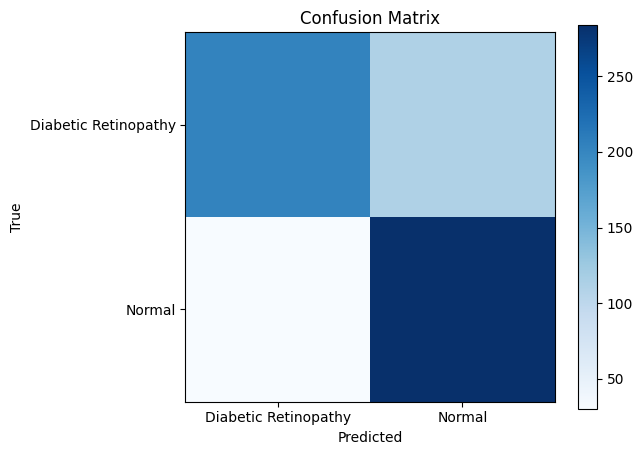

In [62]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_in_numpy, y_pred_in_numpy)
print(cm)

# Create labels for the matrix
labels = list(data_sets['test'].class_indices.keys())

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

# Set tick marks and labels
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=0)
plt.yticks(tick_marks, labels)

# Set axis labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.tight_layout()
plt.show()

In [63]:
fpr, tpr, thresholds = roc_curve(y_true_in_numpy, y_pred_in_numpy)

In [64]:
roc_auc = auc(fpr, tpr)

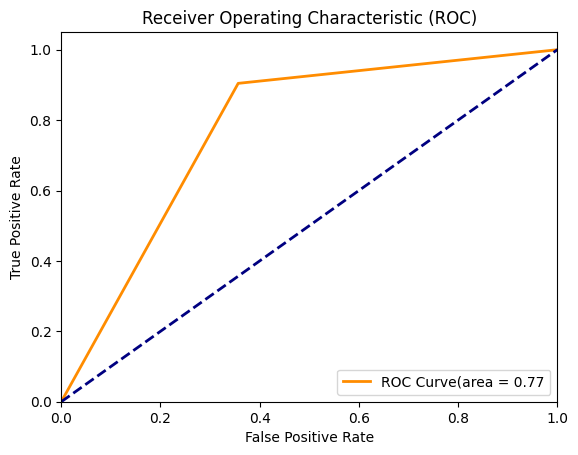

In [65]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color = 'darkorange',
         lw = lw, label = 'ROC Curve(area = %0.2f' %roc_auc)
plt.plot([0,1], [0,1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc = 'lower right')

In [66]:
roc_auc_score_ = roc_auc_score(y_true_in_numpy, y_pred_in_numpy)
print(f'ROC AUC Score: {roc_auc_score_:.4f}') 

ROC AUC Score: 0.7739


## Save the model

In [67]:
# model.save('')

## Use trained model for prediction

In [68]:
from tensorflow.keras.models import load_model, model_from_json, save_model

saved_model = load_model('D:\\Kuliah\\Proyek Akhir 2022\\eye-disease-classification-app\\deep-learning-model\\trained_model\\efficientnetv2b2_dr_best_model.h5', compile=True)

In [69]:
new_prediction_result = saved_model.predict(data_sets['test'])
print('Number of new predicted images:', len(new_prediction_result))
print('New prediction result:', new_prediction_result)
print('New prediction result shape:', new_prediction_result.shape)

new_predictions_df = pd.DataFrame(new_prediction_result)

20/20 [==============================] - 21s 847ms/step
Number of new predicted images: 628
New prediction result: [[6.97679162e-01]
 [6.67766809e-01]
 [2.83964962e-01]
 [8.24116588e-01]
 [5.36964059e-01]
 [1.48516996e-02]
 [8.34208906e-01]
 [5.06944120e-01]
 [1.87359914e-01]
 [3.96982208e-02]
 [6.44144356e-01]
 [2.57809103e-01]
 [1.03931287e-02]
 [9.37237561e-01]
 [5.10672145e-02]
 [6.68957531e-01]
 [8.17490637e-01]
 [6.90359890e-01]
 [6.63922846e-01]
 [2.84344107e-01]
 [2.08428174e-01]
 [6.21818900e-01]
 [5.49926102e-01]
 [2.30683804e-01]
 [8.83470476e-01]
 [3.94871593e-01]
 [1.04165927e-01]
 [3.55269700e-01]
 [7.12243497e-01]
 [3.79849821e-01]
 [6.41592026e-01]
 [6.34759843e-01]
 [6.32819653e-01]
 [4.79061544e-01]
 [5.45087457e-01]
 [3.98688093e-02]
 [1.50719769e-02]
 [1.48120075e-02]
 [3.53264093e-01]
 [5.90276301e-01]
 [4.93039563e-02]
 [5.48283279e-01]
 [4.19373699e-02]
 [2.99316901e-03]
 [1.62982810e-02]
 [1.72476675e-02]
 [7.34306723e-02]
 [5.01245618e-01]
 [3.09386589e-02]
 [4

In [70]:
new_predictions_df

,0
0,0.697679
1,0.667767
2,0.283965
3,0.824117
4,0.536964
...,...
623,0.883025
624,0.798655
625,0.755495
626,0.962783


In [71]:
# Converts each predicted value into labels

new_predictions_df['y_pred'] = new_predictions_df[0].apply(lambda x: 1 if x >= 0.5 else 0)
new_predictions_df

,0,y_pred
0,0.697679,1
1,0.667767,1
2,0.283965,0
3,0.824117,1
4,0.536964,1
...,...,...
623,0.883025,1
624,0.798655,1
625,0.755495,1
626,0.962783,1


In [72]:
# Add y_true into new_predictions_df

print(data_sets['test'].classes)
new_predictions_df['y_true'] = data_sets['test'].classes
new_predictions_df

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

,0,y_pred,y_true
0,0.697679,1,0
1,0.667767,1,0
2,0.283965,0,0
3,0.824117,1,0
4,0.536964,1,0
...,...,...,...
623,0.883025,1,1
624,0.798655,1,1
625,0.755495,1,1
626,0.962783,1,1


In [73]:
new_predictions_df.columns = ['prediction_results', 'y_pred', 'y_true']
new_predictions_df

,prediction_results,y_pred,y_true
0,0.697679,1,0
1,0.667767,1,0
2,0.283965,0,0
3,0.824117,1,0
4,0.536964,1,0
...,...,...,...
623,0.883025,1,1
624,0.798655,1,1
625,0.755495,1,1
626,0.962783,1,1


In [74]:
new_y_pred_in_numpy = np.array(new_predictions_df['y_pred'])
new_y_pred_in_numpy

array([1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [75]:
new_y_true_in_numpy = np.array(new_predictions_df['y_true'])
new_y_true_in_numpy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [76]:
# Creating CSV file path and its headers

csv_file_path = 'D:\\Kuliah\\Proyek Akhir 2022\\new_test_dataset_dr_normal.csv'
headers = ['Image', 'Label']

In [77]:
# Write the CSV file

with open(csv_file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(headers)

In [78]:
# Fill the CSV file with the image path and their label

supported_extensions = ['.png', '.jpg', '.jpeg']

for root, dirs, files in os.walk('D:\\Kuliah\\Proyek Akhir 2022\\Dataset (DR-Normal) (Splitted)\\test'):
    for file in files:
        if any(file.lower().endswith(ext) for ext in supported_extensions):
            image_path = os.path.join(root, file)
            label = os.path.basename(root)
            with open(csv_file_path, 'a', newline='') as csv_file:
                writer = csv.writer(csv_file)
                writer.writerow([file, label])

In [79]:
# Load and preview the CSV dataset file

new_test_dr_df = pd.read_csv('D:\\Kuliah\\Proyek Akhir 2022\\new_test_dataset_dr_normal.csv')
new_test_dr_df

,Image,Label
0,dr - 5 - 1 (102).jpg,Diabetic Retinopathy
1,dr - 5 - 1 (122).jpg,Diabetic Retinopathy
2,dr - 5 - 1 (147).jpg,Diabetic Retinopathy
3,dr - 5 - 1 (151).jpg,Diabetic Retinopathy
4,dr - 5 - 1 (184).jpg,Diabetic Retinopathy
...,...,...
623,dr - 5 - 0 (945).jpg,Normal
624,dr - 5 - 0 (954).jpg,Normal
625,dr - 5 - 0 (974).jpg,Normal
626,dr - 5 - 0 (985).jpg,Normal


Diabetic Retinopathy    314
Normal                  314
Name: Label, dtype: int64

Total predicted images: 628


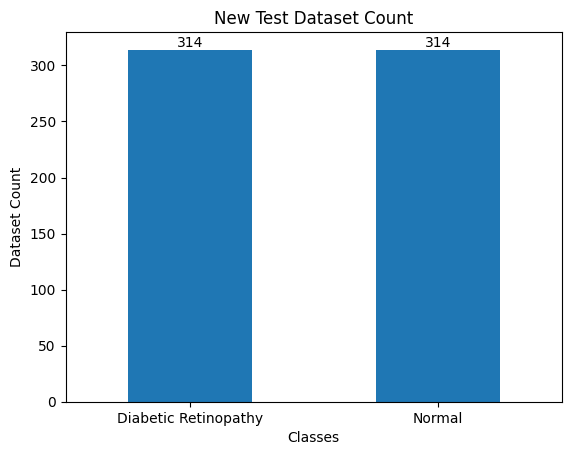

In [80]:
new_test_dr_df['Label'].value_counts()
print(new_test_dr_df['Label'].value_counts())

# View the above in a bar graph
new_test_df_chart = new_test_dr_df.groupby('Label')['Image'].nunique().plot(
    kind='bar',
    title='New Test Dataset Count',
    xlabel='Classes',
    ylabel='Dataset Count',
    rot=0
)

new_test_df_chart.bar_label(new_test_df_chart.containers[0])

# Lets print the total predicted images 
print("\nTotal predicted images:", new_test_dr_df.shape[0])



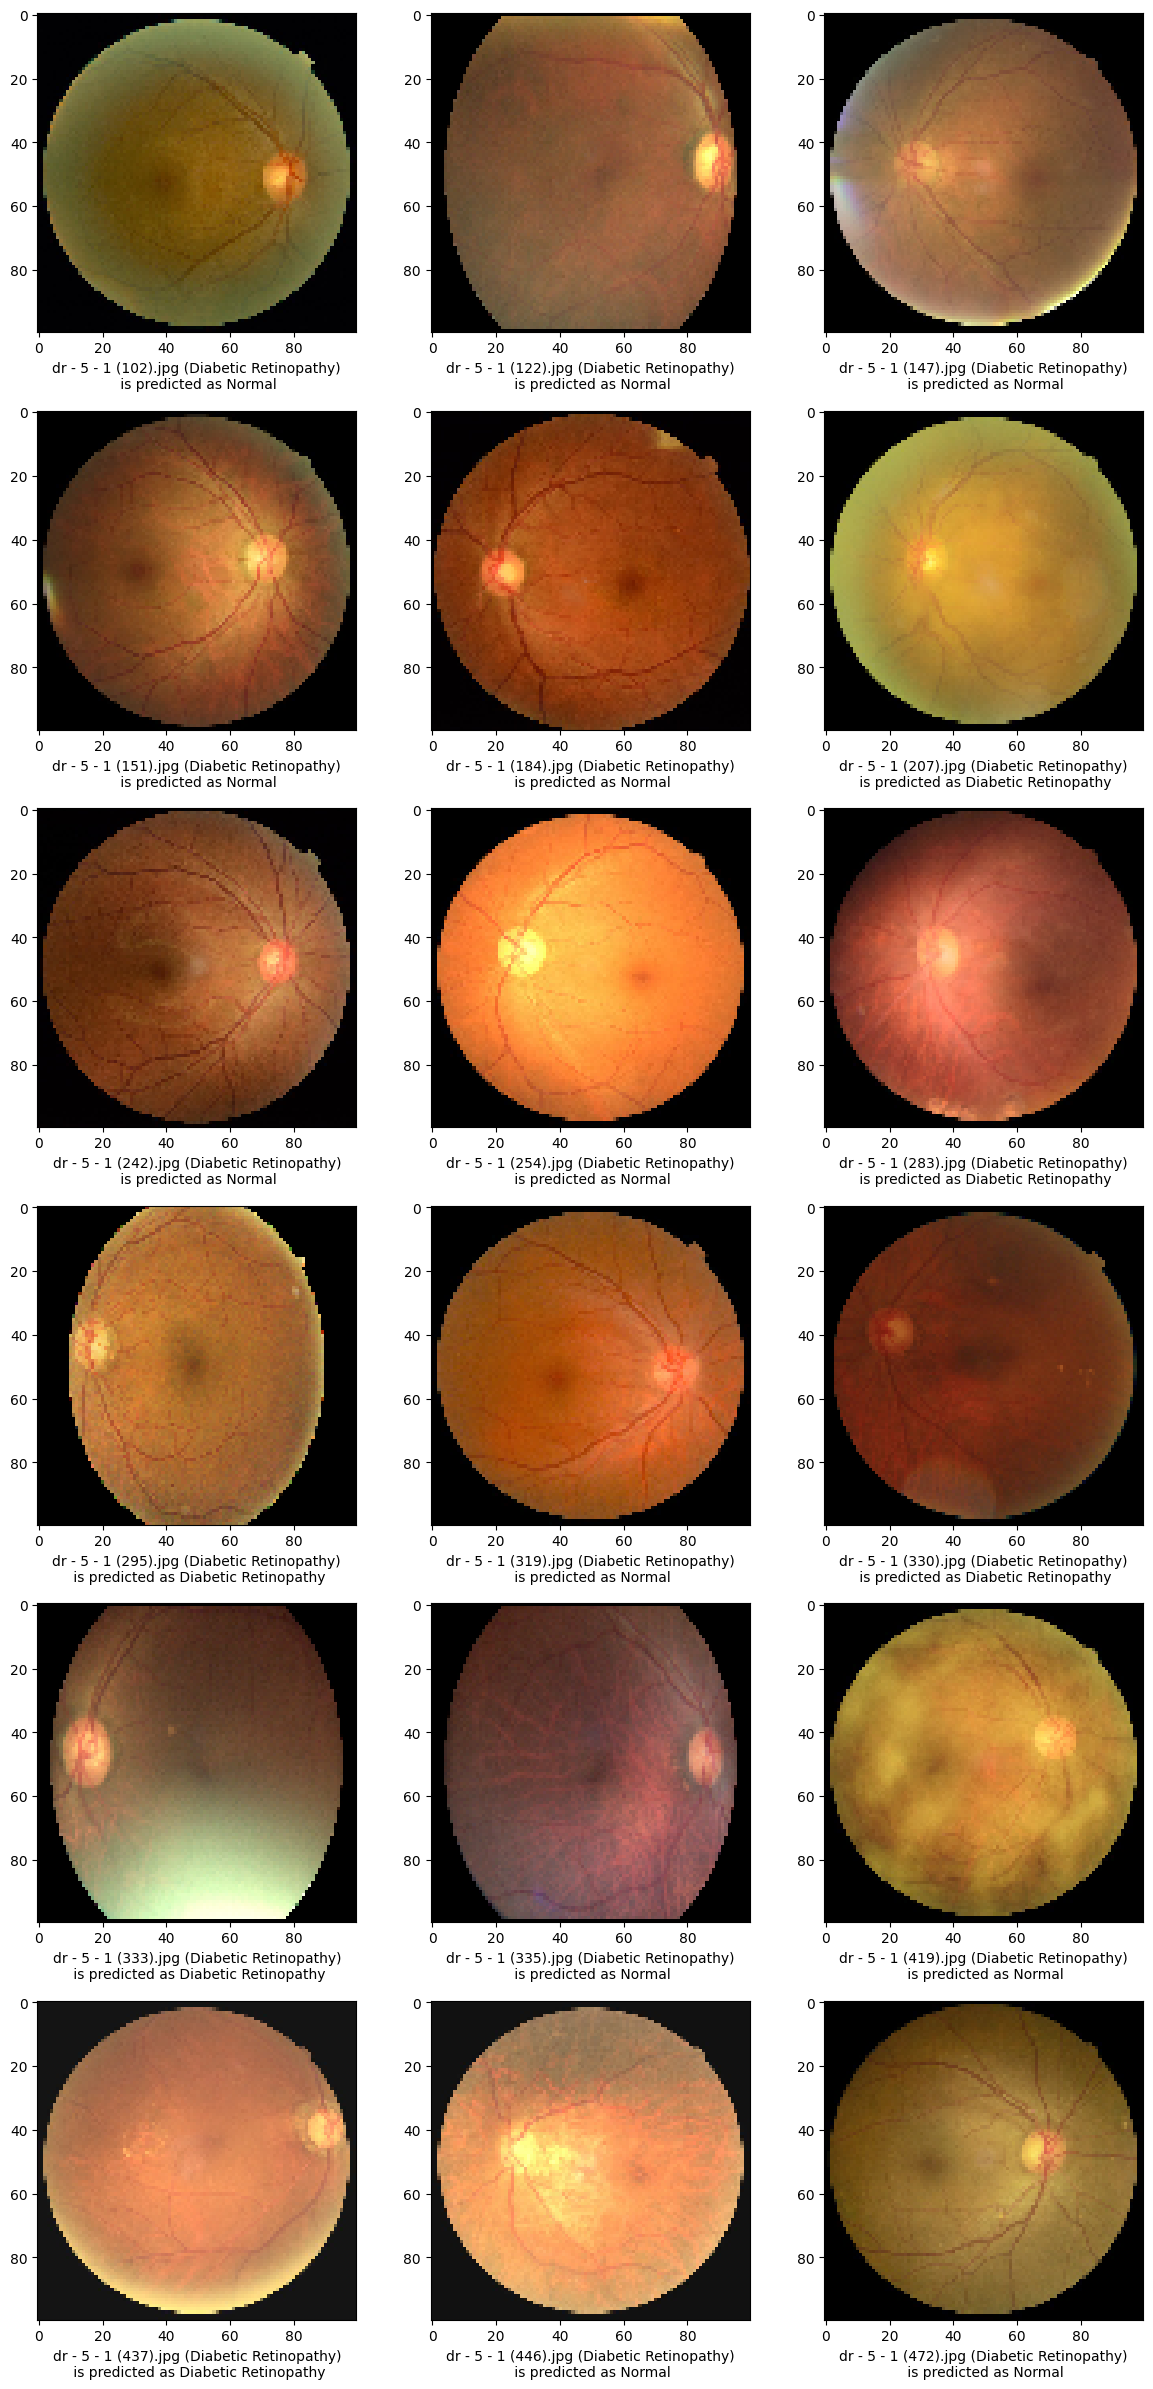

In [81]:
from tensorflow.keras.preprocessing.image import load_img

sample_test = new_test_dr_df.head(18)
sample_test.head()
class_indices = data_sets['test'].class_indices
plt.figure(figsize=(12, 24))

for index, row in sample_test.iterrows():
    filename = row['Image']
    category = row['Label']
    y_pred = predictions_df['y_pred'][index]
    classes = list(filter(lambda x: class_indices[x] == y_pred, class_indices))[0]
    img = load_img('D:\\Kuliah\\Proyek Akhir 2022\\Dataset (DR-Normal) (Splitted)\\test\\Diabetic Retinopathy\\' + filename, target_size=IMG_SIZE) #rescale(1./255)
    plt.subplot(6, 3, index+1)      
    plt.imshow(img)
    plt.xlabel(filename + f" ({category})\n is predicted as {classes}")

plt.tight_layout()
plt.show()

In [82]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(new_y_true_in_numpy, new_y_pred_in_numpy)))

print('Micro Precision: {:.2f}'.format(precision_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='weighted')))
print('Weighted F1-score: {:.2f}\n'.format(f1_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='weighted')))

print('\nClassification Report\n')
print(classification_report(new_y_true_in_numpy, new_y_pred_in_numpy, target_names=class_names))




Accuracy: 0.81

Micro Precision: 0.81
Micro Recall: 0.81
Micro F1-score: 0.81

Macro Precision: 0.82
Macro Recall: 0.81
Macro F1-score: 0.81

Weighted Precision: 0.82
Weighted Recall: 0.81
Weighted F1-score: 0.81


Classification Report

                      precision    recall  f1-score   support

Diabetic Retinopathy       0.87      0.72      0.79       314
              Normal       0.76      0.89      0.82       314

            accuracy                           0.81       628
           macro avg       0.82      0.81      0.81       628
        weighted avg       0.82      0.81      0.81       628



In [83]:
# Let's try, if the model can predict just one image

from tensorflow.keras.preprocessing import image

def predict_one_image(img_path, model=model):
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    
    print(img_array.shape) 
    print(type(img_array))
    
    prediction_result = model.predict(img_array)
    
    print('Prediction_result:', prediction_result)    
    print('Prediction_result shape:', prediction_result.shape)    
    print('Prediction_result type:', type(prediction_result))    

    if prediction_result[0] > 0.5:
        predicted_class = class_names[1]
    else:
        predicted_class = class_names[0]
    
    print('Prediction_class:', predicted_class)

dr_normal_test_image = test_image_source = 'D:\\Kuliah\\Proyek Akhir 2022\\eye-disease-classification-app\\deep-learning-model\\glaucoma_test_images\\mixed - 10 - normal (661).jpg'
predict_one_image(dr_normal_test_image, saved_model)

(1, 100, 100, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
1/1 [==============================] - 5s 5s/step
Prediction_result: [[0.5462074]]
Prediction_result shape: (1, 1)
Prediction_result type: <class 'numpy.ndarray'>
Prediction_class: Normal
